In [6]:
################chapter07_begins####################
BUCKET='zeta-sol-254211bucket'
os.environ['BUCKET'] = BUCKET

In [7]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

In [8]:
traindays = spark.read \
    .option("header", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))

In [9]:
traindays.createOrReplaceTempView('traindays')

In [10]:
spark.sql("SELECT * from traindays LIMIT 5").show()

+----------+------------+
|   FL_DATE|is_train_day|
+----------+------------+
|2015-01-01|        True|
|2015-01-02|       False|
|2015-01-03|       False|
|2015-01-04|        True|
|2015-01-05|        True|
+----------+------------+



In [24]:
from pyspark.sql.types import StringType, FloatType, StructType, StructField
header ='FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'
def get_structfield(colname):
   if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE', 'TAXI_OUT']:
      return StructField(colname, FloatType(), True)
   else:
      return StructField(colname, StringType(), True)

schema = StructType([get_structfield(colname) for colname in header.split(',')])

In [25]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET)

In [26]:
flights = spark.read\
            .schema(schema)\
            .csv(inputs)
flights.createOrReplaceTempView('flights')

In [27]:
trainquery = """
SELECT
  f.*
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True'
"""

In [28]:
traindata = spark.sql(trainquery)

In [29]:
traindata.head(2)

[Row(FL_DATE=u'2015-03-01', UNIQUE_CARRIER=u'AA', AIRLINE_ID=u'19805', CARRIER=u'AA', FL_NUM=u'1', ORIGIN_AIRPORT_ID=u'12478', ORIGIN_AIRPORT_SEQ_ID=u'1247802', ORIGIN_CITY_MARKET_ID=u'31703', ORIGIN=u'JFK', DEST_AIRPORT_ID=u'12892', DEST_AIRPORT_SEQ_ID=u'1289203', DEST_CITY_MARKET_ID=u'32575', DEST=u'LAX', CRS_DEP_TIME=u'2015-03-01T14:00:00', DEP_TIME=u'2015-03-01T13:54:00', DEP_DELAY=-6.0, TAXI_OUT=22.0, WHEELS_OFF=u'2015-03-01T14:16:00', WHEELS_ON=u'2015-03-01T20:21:00', TAXI_IN=u'14.00', CRS_ARR_TIME=u'2015-03-01T20:35:00', ARR_TIME=u'2015-03-01T20:35:00', ARR_DELAY=0.0, CANCELLED=u'0.00', CANCELLATION_CODE=None, DIVERTED=u'0.00', DISTANCE=2475.0, DEP_AIRPORT_LAT=u'40.63972222', DEP_AIRPORT_LON=u'-73.77888889', DEP_AIRPORT_TZOFFSET=u'-18000.0', ARR_AIRPORT_LAT=u'33.94250000', ARR_AIRPORT_LON=u'-118.40805556', ARR_AIRPORT_TZOFFSET=u'-28800.0', EVENT=None, NOTIFY_TIME=None),
 Row(FL_DATE=u'2015-03-01', UNIQUE_CARRIER=u'AA', AIRLINE_ID=u'19805', CARRIER=u'AA', FL_NUM=u'2', ORIGIN_AIRP

In [30]:
traindata.describe().show()

+-------+----------+--------------+------------------+-------+------------------+-----------------+---------------------+---------------------+------+------------------+-------------------+-------------------+------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-----------------+-------------------+-------------------+------------------+-------------------+-----------------+--------------------+-----------------+-----------------+------------------+--------------------+-----------------+------------------+--------------------+-----+-----------+
|summary|   FL_DATE|UNIQUE_CARRIER|        AIRLINE_ID|CARRIER|            FL_NUM|ORIGIN_AIRPORT_ID|ORIGIN_AIRPORT_SEQ_ID|ORIGIN_CITY_MARKET_ID|ORIGIN|   DEST_AIRPORT_ID|DEST_AIRPORT_SEQ_ID|DEST_CITY_MARKET_ID|  DEST|       CRS_DEP_TIME|           DEP_TIME|         DEP_DELAY|          TAXI_OUT|         WHEELS_OFF|          WHEELS_ON|          TAXI_IN|       CRS_ARR_TIME|     

In [31]:
trainquery2 = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.dep_delay IS NOT NULL AND 
  f.arr_delay IS NOT NULL
"""

In [34]:
traindata = spark.sql(trainquery2)

In [35]:
traindata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|            453391|            453391|            453391|           453391|
|   mean|10.524110535939178|15.995617469248398|6.1332007031458495|822.8666493159326|
| stddev|37.994050496122405| 9.192042072828558|40.599413916731116|601.1302202926496|
|    min|             -41.0|               1.0|             -87.0|             31.0|
|    max|            1589.0|             180.0|            1576.0|           4983.0|
+-------+------------------+------------------+------------------+-----------------+



In [39]:
trainquery3 = """
SELECT
  DEP_DELAY, TAXI_OUT, ARR_DELAY, DISTANCE
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.CANCELLED == '0.00' AND 
  f.DIVERTED == '0.00'
"""

In [40]:
traindata = spark.sql(trainquery3)

In [41]:
traindata.describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|         ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+------------------+-----------------+
|  count|            453391|            453391|            453391|           453391|
|   mean|10.524110535939178|15.995617469248398|6.1332007031458495|822.8666493159326|
| stddev|37.994050496122405| 9.192042072828558|40.599413916731116|601.1302202926496|
|    min|             -41.0|               1.0|             -87.0|             31.0|
|    max|            1589.0|             180.0|            1576.0|           4983.0|
+-------+------------------+------------------+------------------+-----------------+



In [42]:
def to_example(raw_data_point):
  return LabeledPoint(\
              float(raw_data_point['ARR_DELAY'] < 15), # on-time? \
              [ \
                  raw_data_point['DEP_DELAY'], \
                  raw_data_point['TAXI_OUT'], \
                  raw_data_point['DISTANCE'], \
              ])

In [43]:
examples = traindata.rdd.map(to_example)

In [44]:
lrmodel = LogisticRegressionWithLBFGS.train(examples, intercept=True)

In [45]:
print lrmodel.weights,lrmodel.intercept

[-0.16411921744187452,-0.13393724607433352,0.0002810494933260028] 5.25909681204


In [46]:
lrmodel.predict([6.0,12.0,594.0])

1

In [47]:
lrmodel.predict([36.0,12.0,594.0])

0

In [48]:
lrmodel.clearThreshold()

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style("whitegrid")

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


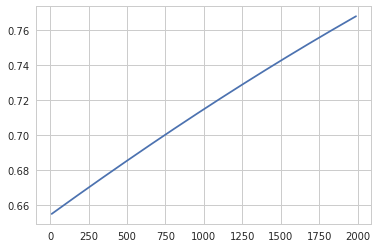

In [51]:
dist = np.arange(10, 2000, 10)
prob = [lrmodel.predict([20, 10, d]) for d in dist]
plt.plot(dist, prob)

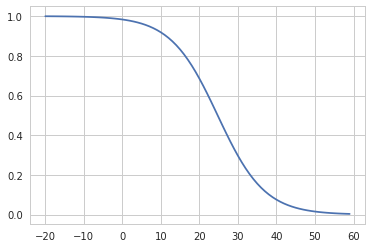

In [52]:
delay = np.arange(-20, 60, 1)
prob = [lrmodel.predict([d, 10, 500]) for d in delay]
ax = plt.plot(delay, prob)

In [53]:
lrmodel.setThreshold(0.7)

In [54]:
MODEL_FILE='gs://' + BUCKET + '/flights/sparkmloutput/model'
lrmodel.save(sc, MODEL_FILE)

In [55]:
from pyspark.mllib.classification import LogisticRegressionModel
lrmodel = LogisticRegressionModel.load(sc, MODEL_FILE)
lrmodel.setThreshold(0.7)

In [56]:
print lrmodel.predict([36.0,12.0,594.0])

0


In [57]:
testquery = trainquery.replace(\
         "t.is_train_day == 'True'","t.is_train_day == 'False'")
print testquery


SELECT
  f.*
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'False'



In [60]:
testdata = spark.sql(testquery)
examples = testdata.rdd.map(to_example)

In [61]:
labelpred = examples.map(lambda p: \
           (p.label, lrmodel.predict(p.features)))

In [63]:
def eval(labelpred):
    cancel = labelpred.filter(lambda (label, pred): pred == 1)
    nocancel = labelpred.filter(lambda (label, pred): pred == 0)
    corr_cancel = cancel.filter(lambda (label, pred): \
                                        label == pred).count()
    corr_nocancel = nocancel.filter(lambda (label, pred): \
                                        label == pred).count()
    return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel.count(), \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel.count()\
           }

In [65]:
print eval(labelpred)

{'correct_cancel': 0.9655800844081103, 'total_noncancel': 29965, 'correct_noncancel': 0.7423327215084266, 'total_cancel': 135532}


In [76]:
#should be full dataset, it is actually one shard during development and decision threshold of 0.7
lrmodel.clearThreshold() # so it returns probabilities
labelpred = examples.map(lambda p: \
                         (p.label, lrmodel.predict(p.features)))

In [86]:
def eval(labelpred):
    cancel = labelpred.filter(lambda (label, pred): pred < 0.7)
    nocancel = labelpred.filter(lambda (label, pred): pred >= 0.7)
    corr_cancel = cancel.filter(lambda (label, pred): \
                             label == int(pred >= 0.7)).count()
    corr_nocancel = nocancel.filter(lambda (label, pred): \
                             label == int(pred >= 0.7)).count()
    cancel_denom = cancel.count()
    nocancel_denom = nocancel.count()
    if cancel_denom == 0:
        cancel_denom = 1
    if nocancel_denom == 0:
        nocancel_denom = 1
    return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel_denom, \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel_denom \
           }

In [87]:
print eval(labelpred)

{'correct_cancel': 0.3014749262536873, 'total_noncancel': 2045, 'correct_noncancel': 0.7471882640586797, 'total_cancel': 1695}


In [82]:
#one shard of data and marginal(between 0.65 and 0.75) near decision threshold of 0.7
labelpred = labelpred.filter(lambda (label, pred):\
                         pred > 0.65 and pred < 0.75)

In [83]:
def eval(labelpred):
  cancel = labelpred.filter(lambda (label, pred): pred < 0.7)
  nocancel = labelpred.filter(lambda (label, pred): pred >= 0.7)
  corr_cancel = cancel.filter(lambda (label, pred): \
                             label == int(pred >= 0.7)).count()
  corr_nocancel = nocancel.filter(lambda (label, pred): \
                             label == int(pred >= 0.7)).count()
  cancel_denom = cancel.count()
  nocancel_denom = nocancel.count()
  if cancel_denom == 0:
        cancel_denom = 1
  if nocancel_denom == 0:
        nocancel_denom = 1
  return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel.count(), \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel.count()\
           }

In [84]:
# keep only those examples near the decision threshold
print eval(labelpred)

{'correct_cancel': 0.3014749262536873, 'total_noncancel': 2045, 'correct_noncancel': 0.7471882640586797, 'total_cancel': 1695}


In [92]:
################feature_engineering#############
cancel = labelpred.filter(lambda (label, pred): pred < 0.7)
nocancel = labelpred.filter(lambda (label, pred): pred >= 0.7)
totsqe = labelpred.map(lambda (label, pred): \
                       (label-pred)*(label-pred)).sum()
rmse=np.sqrt(totsqe/float(cancel.count() + nocancel.count()))

In [93]:
from pyspark.sql.functions import rand
SEED = 13
traindays = traindays.withColumn("holdout", rand(SEED) > 0.8)  # 20%
traindays.createOrReplaceTempView('traindays')

In [94]:
traindays.head(5)

[Row(FL_DATE=u'2015-01-01', is_train_day=u'True', holdout=False),
 Row(FL_DATE=u'2015-01-02', is_train_day=u'False', holdout=True),
 Row(FL_DATE=u'2015-01-03', is_train_day=u'False', holdout=False),
 Row(FL_DATE=u'2015-01-04', is_train_day=u'True', holdout=False),
 Row(FL_DATE=u'2015-01-05', is_train_day=u'True', holdout=True)]

In [106]:
trainqueryn = """
SELECT 
  * 
  FROM flights f 
  JOIN traindays t 
  ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  t.holdout == False AND
  f.CANCELLED == '0.00' AND
  f.DIVERTED == '0.00'
  """

In [ ]:
traindata = spark.sql(trainqueryn)

In [112]:
traindata.head()

Row(FL_DATE=u'2015-03-14', UNIQUE_CARRIER=u'EV', AIRLINE_ID=u'20366', CARRIER=u'EV', FL_NUM=u'4545', ORIGIN_AIRPORT_ID=u'12266', ORIGIN_AIRPORT_SEQ_ID=u'1226603', ORIGIN_CITY_MARKET_ID=u'31453', ORIGIN=u'IAH', DEST_AIRPORT_ID=u'12278', DEST_AIRPORT_SEQ_ID=u'1227802', DEST_CITY_MARKET_ID=u'30928', DEST=u'ICT', CRS_DEP_TIME=u'2015-03-15T00:05:00', DEP_TIME=u'2015-03-15T00:46:00', DEP_DELAY=41.0, TAXI_OUT=13.0, WHEELS_OFF=u'2015-03-15T00:59:00', WHEELS_ON=u'2015-03-15T02:13:00', TAXI_IN=u'8.00', CRS_ARR_TIME=u'2015-03-15T01:49:00', ARR_TIME=u'2015-03-15T02:21:00', ARR_DELAY=32.0, CANCELLED=u'0.00', CANCELLATION_CODE=None, DIVERTED=u'0.00', DISTANCE=542.0, DEP_AIRPORT_LAT=u'29.98444444', DEP_AIRPORT_LON=u'-95.34138889', DEP_AIRPORT_TZOFFSET=u'-18000.0', ARR_AIRPORT_LAT=u'37.65000000', ARR_AIRPORT_LON=u'-97.43305556', ARR_AIRPORT_TZOFFSET=u'-18000.0', EVENT=None, NOTIFY_TIME=None)

In [ ]:
def to_example(raw_data_point):
  return LabeledPoint(\
              float(raw_data_point['ARR_DELAY'] < 15), #ontime \
              [ \
                  raw_data_point['DEP_DELAY'], # DEP_DELAY \
                  raw_data_point['DISTANCE'], # TAXI_OUT \
              ])

In [114]:
examples = traindata.rdd.map(to_example)

In [ ]:
lrmodel = LogisticRegressionWithLBFGS.train(examples, intercept=True)
print lrmodel.weights,lrmodel.intercept

In [ ]:
lrmodel.setThreshold(0.7) # cancel if prob-of-ontime < 0.7

In [110]:
#traindata = spark.sql(trainqueryn).repartition(1000)

In [ ]:
#evaldata = spark.sql(evalquery).repartition(1000)

In [ ]:
#option1: scaling
def to_example(raw_data_point):
  return LabeledPoint(\
              float(raw_data_point['ARR_DELAY'] < 15), #ontime \
              [ \
                  raw_data_point['DEP_DELAY'] / 30, \
                  (raw_data_point['DISTANCE'] / 1000) - 1, \
                  (raw_data_point['TAXI_OUT'] / 10) - 1, \
              ])

In [ ]:
#clipping
def to_example(raw_data_point):
  def clip(x):
     if (x < -1):
        return -1
     if (x > 1):
        return 1
     return x
  return LabeledPoint(\
              float(raw_data_point['ARR_DELAY'] < 15), #ontime \
              [ \
                  clip(raw_data_point['DEP_DELAY'] / 30), \
                  clip((raw_data_point['DISTANCE'] / 1000) - 1), \
                  clip((raw_data_point['TAXI_OUT'] / 10) - 1), \
              ])

In [ ]:
#feature transform1: Given a departure timestamp and a time zone offset
def to_example(raw_data_point):
  def get_local_hour(timestamp, correction):
      import datetime
      TIME_FORMAT = '%Y-%m-%dT%H:%M:%S'
      t = datetime.datetime.strptime(timestamp, TIME_FORMAT)
      d = datetime.timedelta(seconds=correction)
      t = t + d
      return t.hour
  return LabeledPoint(\
              float(raw_data_point['ARR_DELAY'] < 15), #ontime \
              [ \
                  raw_data_point['DEP_DELAY'], \
                  raw_data_point['TAXI_OUT'], \
                  get_local_hour(raw_data_point['DEP_TIME'], \
                           raw_data_point['DEP_AIRPORT_TZOFFSET'])
              ])

In [ ]:
#feature transform2:sin(theta) and cos(theta)
def to_example(raw_data_point):
  def get_local_hour(timestamp, correction):
      import datetime
      TIME_FORMAT = '%Y-%m-%dT%H:%M:%S'
      t = datetime.datetime.strptime(timestamp, TIME_FORMAT)
      d = datetime.timedelta(seconds=correction)
      t = t + d
      theta = np.radians(360 * t.hour / 24.0)
      return [np.sin(theta), np.cos(theta)]
 
  features = [ \
                  raw_data_point['DEP_DELAY'], \
                  raw_data_point['TAXI_OUT'], \
              ]
  features.extend(get_local_hour(raw_data_point['DEP_TIME'],
                                 raw_data_point['DEP_AIRPORT_TZOFFSET']))
  return LabeledPoint(\
              float(raw_data_point['ARR_DELAY'] < 15), #ontime \
              features)

In [ ]:
#feature transform3:bucketize
def get_category(hour):
  if hour < 6 or hour > 20:
     return [1, 0, 0]  # night
  if hour < 10:
     return [0, 1, 0] # morning
  if hour < 17:
     return [0, 0, 1] # mid-day
  else:
     return [0, 0, 0] # evening

def get_local_hour(timestamp, correction):
  ...
   return get_category(t.hour)

In [ ]:
#Categorical Variables: One-hot encoding is available as a prebuilt feature transformation in Spark; 
#we can add a new column of vectors to the traindata data frame using this code:
def add_categorical(df):
   from pyspark.ml.feature import OneHotEncoder, StringIndexer
   indexer = StringIndexer(inputCol='ORIGIN',
                           outputCol='origin_index')
   index_model = indexer.fit(df)  # Step 1
   indexed = index_model.transform(df)  # Step 2
   encoder = OneHotEncoder(inputCol='origin_index',
                           outputCol='origin_onehot')
   return encoder.transform(indexed) # Step 3
traindata = add_categorical(traindata)

#Here are the three steps:
#1.Create an index from origin airport codes (e.g., DFW) to an origin index (e.g., 143).
#2.Transform the dataset so that all flights with ORIGIN=DFW have origin_index=143.
#3.One-hot encode the index into a binary vector that is used as input to training.

In [ ]:
#During evaluation, the same change needs to be made to the dataset, except that the index model will need to be 
#reused from training (so that DFW continues to map to 143). In other words, we need to save the index_model and carry out the 
#last three lines before prediction. So, we modify the add_categorical() method appropriately:23 experiment.py
index_model = 0
def add_categorical(df, train=False):
   from pyspark.ml.feature import OneHotEncoder, StringIndexer
   if train:
       indexer = StringIndexer(inputCol='ORIGIN',
                           outputCol='origin_index')
       index_model = indexer.fit(df)
   indexed = index_model.transform(df)
   encoder = OneHotEncoder(inputCol='origin_index',
                           outputCol='origin_onehot')
   return encoder.transform(indexed)
traindata = add_categorical(traindata, train=True)
…
evaldata = add_categorical(evaldata)

#This is bookkeeping to which we need to pay careful attention because doing this sort of thing incorrectly will result
#in training–serving skew. Spark provides a Pipeline mechanism to help you record which operations you carried out on 
#the dataset so that you can repeat them when evaluating, but it introduces yet another level of abstraction into an already 
#complex topic. During prediction, things become even more complicated. No longer is it simply a matter of calling lrmodel.predict(). 
#Instead, you will need to first construct a dataframe out of your raw input data, apply these transforms, and finally invoke the 
#actual model.

In [ ]:
#One way of reducing the explosion of input features caused by one-hot encoding is to carry out dimensionality reduction. 
#The idea is to pass in the one-hot encoded set and ask the machine learning algorithm itself to come up with weights to combine 
#these columns into, say, four features that are used downstream in the model. This is called creating an embedding.

In [108]:
#Evaluate model on the heldout data
evalquery = trainqueryn.replace("t.holdout == False", \
                               "t.holdout == True")

In [ ]:
print evalquery

In [ ]:
evaldata = spark.sql(evalquery)
examples = evaldata.rdd.map(to_example)

In [ ]:
def eval(labelpred):
    cancel = labelpred.filter(lambda (label, pred): pred == 0)
    nocancel = labelpred.filter(lambda (label, pred): pred == 1)
    corr_cancel = cancel.filter(lambda (label, pred): label == pred).count()
    corr_nocancel = nocancel.filter(lambda (label, pred): label == pred).count()
    
    cancel_denom = cancel.count()
    nocancel_denom = nocancel.count()
    if cancel_denom == 0:
        cancel_denom = 1
    if nocancel_denom == 0:
        nocancel_denom = 1

    return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel_denom, \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel_denom \
           }

In [ ]:
labelpred = examples.map(lambda p: (p.label, lrmodel.predict(p.features)))
print eval(labelpred)